#### Matplotlib and Seaborn Visualizations for Final Prez

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, DBSCAN

#### Linear SVM Classifier Performance Statistics

In [2]:
precision=[
    {"topic": "Food & \nDrink", "value":89}, 
    {"topic": "Service", "value":80},
    {"topic": "Ambience", "value":57},
    {"topic": "Value", "value":73}
]

recall=[
    {"topic":"Food & \nDrink", "value":80}, 
    {"topic":"Service", "value":76}, 
    {"topic":"Ambience", "value":71},
    {"topic":"Value", "value":81}
]

precision = pd.DataFrame(precision)
recall = pd.DataFrame(recall)

In [3]:
precision

,topic,value
0,Food & \nDrink,89
1,Service,80
2,Ambience,57
3,Value,73


In [4]:
recall

,topic,value
0,Food & \nDrink,80
1,Service,76
2,Ambience,71
3,Value,81


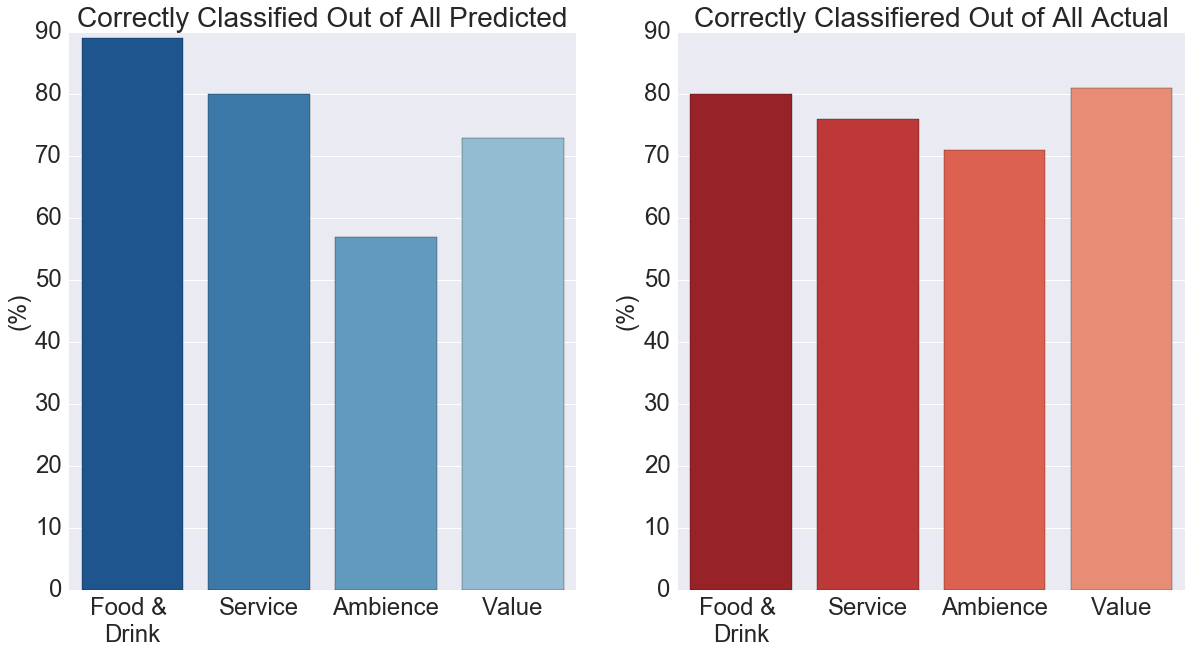

In [5]:
plt.figure(figsize=(20,10))

blues = sns.color_palette("Blues")[5:1:-1]
reds = sns.color_palette("Reds")[5:1:-1]

plt.subplot(1,2,1)
sns.barplot(x="topic", y="value", data=precision, palette=blues)
plt.xlabel("")
plt.ylabel("(%)", fontsize=24)
plt.tick_params(labelsize=24)
plt.title("Correctly Classified Out of All Predicted", fontsize=28)

plt.subplot(1,2,2)
sns.barplot(x="topic", y="value", data=recall, palette=reds)
plt.xlabel("")
plt.ylabel("(%)", fontsize=24)
plt.tick_params(labelsize=24)
plt.title("Correctly Classifiered Out of All Actual", fontsize=28)
plt.savefig("graphics/linear_svm_performance.png")

#### Clustering Visualizations
#### Read in Yelp Data

In [6]:
user = pd.read_pickle("data/yelp/dataframes/yelp_review_user.pkl")
user.head(5)

,location,user_id,topic_food,topic_service,topic_ambience,topic_value,relevant,total
31623,"Madison, WI",C7TFZoVARUIVar5n5VNamg,0,0,0,0,0,3
62595,"Pittsburg, PA",ySPSkuI5oEUOYCoV3tDFhw,0,0,0,0,0,1
60578,"Pittsburg, PA",sKZBaKFKQ3D85yEh_JLWAg,0,0,0,0,0,1
4193,"Charlotte, NC",8I1-3v8-nTjfmjaI2SSnug,0,0,0,0,0,3
41658,"Madison, WI",yS0qbhrEPCx0c6RwNj5_oA,0,0,0,0,0,1


#### Subset to Top 25 Percentile of Users

In [7]:
user = user[(user.relevant>=12) & (user.relevant<=219)]
user.reset_index(drop=True, inplace=True)

#### Calculate % in Each Topic

In [8]:
user["pct_food"] = user["topic_food"] / user["relevant"]
user["pct_service"] = user["topic_service"] / user["relevant"]
user["pct_ambience"] = user["topic_ambience"] / user["relevant"]
user["pct_value"] = user["topic_value"] / user["relevant"]
user.head(5)

,location,user_id,topic_food,topic_service,topic_ambience,topic_value,relevant,total,pct_food,pct_service,pct_ambience,pct_value
0,"Charlotte, NC",qEOUrhX7uhB-9D7uTAKyJg,10,2,1,1,12,20,0.833333,0.166667,0.083333,0.083333
1,"Charlotte, NC",VlCIxw9UOTxLTfE-dMWw0A,9,2,1,1,12,18,0.750000,0.166667,0.083333,0.083333
2,"Charlotte, NC",9jLgxE6Bltubt7Ri4jTC9A,7,3,3,0,12,16,0.583333,0.250000,0.250000,0.000000
3,"Charlotte, NC",KDioFcWlX7avlvftBPDpLQ,6,7,2,1,12,27,0.500000,0.583333,0.166667,0.083333
4,"Charlotte, NC",ctax9ECmvdyYqZJL-XG0pQ,7,3,2,0,12,16,0.583333,0.250000,0.166667,0.000000


#### PCA

In [9]:
reducer = PCA(n_components=2, whiten=True)
reduced = reducer.fit_transform(user[["pct_food","pct_service","pct_ambience","pct_value"]])

reduced = pd.DataFrame(reduced, columns=["PCA_1", "PCA_2"])
user = pd.concat([user, reduced], axis=1)
user.head(5)

,location,user_id,topic_food,topic_service,topic_ambience,topic_value,relevant,total,pct_food,pct_service,pct_ambience,pct_value,PCA_1,PCA_2
0,"Charlotte, NC",qEOUrhX7uhB-9D7uTAKyJg,10,2,1,1,12,20,0.833333,0.166667,0.083333,0.083333,-1.082740,0.792646
1,"Charlotte, NC",VlCIxw9UOTxLTfE-dMWw0A,9,2,1,1,12,18,0.750000,0.166667,0.083333,0.083333,-0.787806,0.547124
2,"Charlotte, NC",9jLgxE6Bltubt7Ri4jTC9A,7,3,3,0,12,16,0.583333,0.250000,0.250000,0.000000,0.166272,-0.684023
3,"Charlotte, NC",KDioFcWlX7avlvftBPDpLQ,6,7,2,1,12,27,0.500000,0.583333,0.166667,0.083333,1.620466,0.799437
4,"Charlotte, NC",ctax9ECmvdyYqZJL-XG0pQ,7,3,2,0,12,16,0.583333,0.250000,0.166667,0.000000,0.131627,-0.135445


#### Viz

In [10]:
##Function to Run DBSCAN Clustering
def dbscan(df, eps, min_samples):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = pd.Series(model.fit_predict(df[["PCA_1","PCA_2"]]), name="cluster")
    
    return pd.concat([df, clusters], axis=1)

##Function to Run Mini-Batch K-Means Clustering
def kmeans(df, n_clusters):
    model = MiniBatchKMeans(n_clusters=n_clusters)
    clusters = pd.Series(model.fit_predict(df[["PCA_1","PCA_2"]]), name="cluster")
    
    return pd.concat([df, clusters], axis=1)

In [31]:
clustered = dbscan(user, eps=0.17, min_samples=35)
clustered["one_cluster"] = 0
clustered.cluster.value_counts()

 0    13946
-1     1603
Name: cluster, dtype: int64

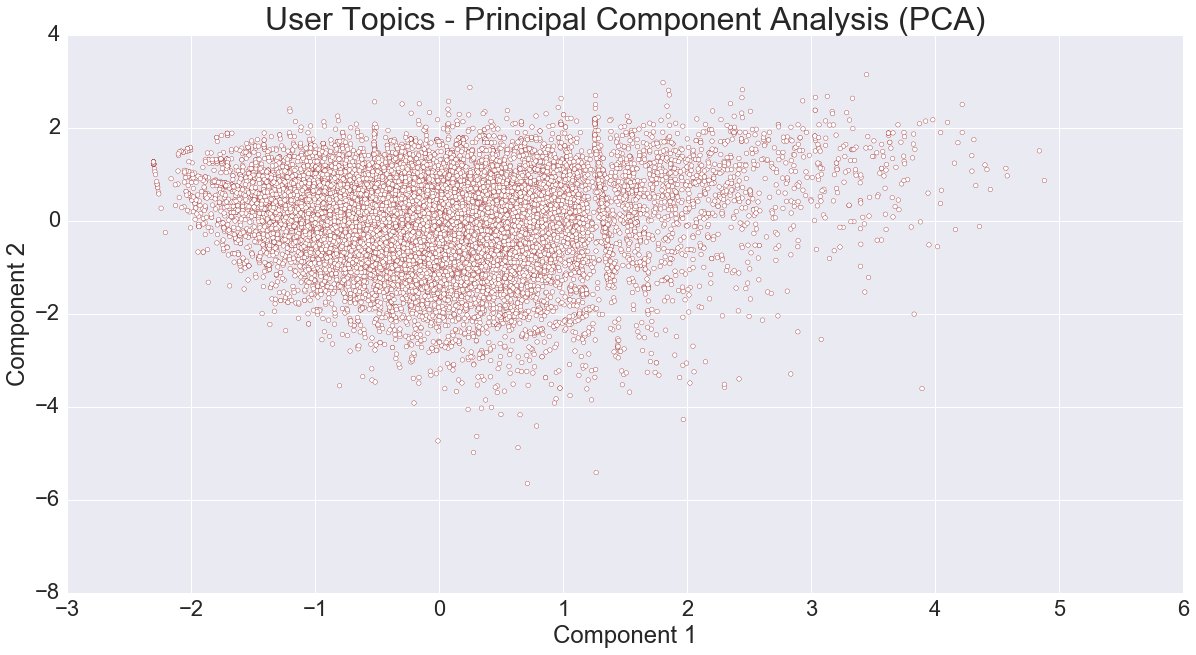

In [43]:
plt.figure(figsize=(20,10))
colors=["#8B0000","#8B0000"]

plt.scatter(clustered.PCA_1, clustered.PCA_2, c=clustered.one_cluster, color=colors)
plt.xlabel("Component 1", fontsize=24)
plt.ylabel("Component 2", fontsize=24)
plt.tick_params(labelsize=22)
plt.title("User Topics - Principal Component Analysis (PCA)", fontsize=32)
plt.savefig("graphics/scatter_all.png")

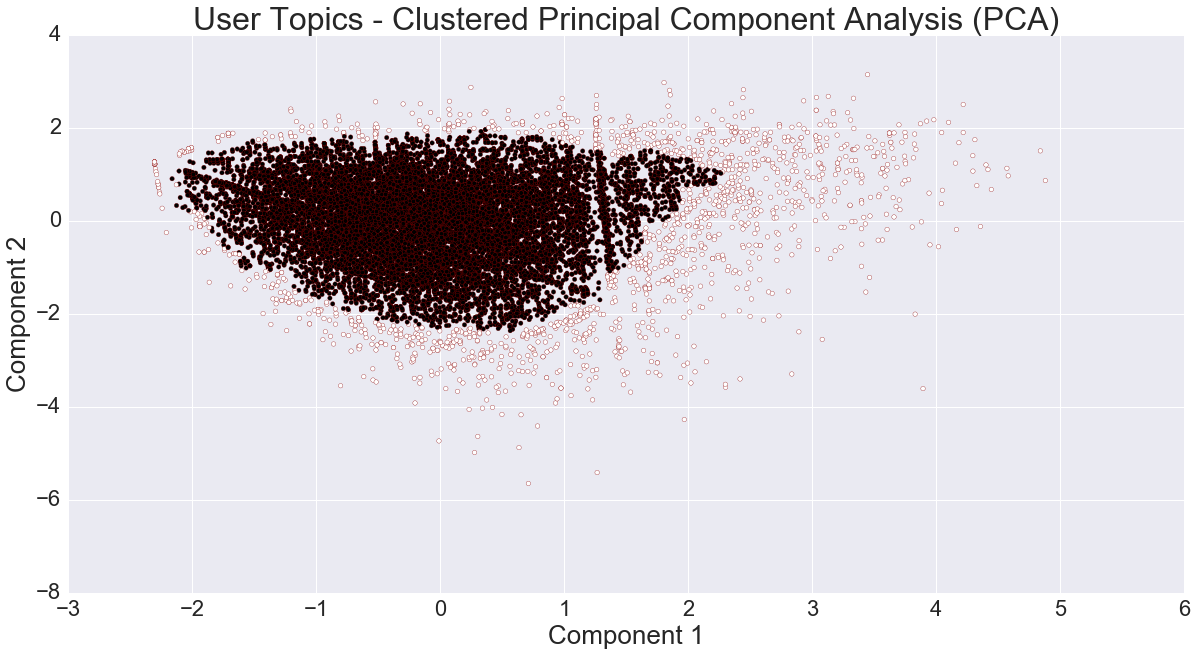

In [42]:
plt.figure(figsize=(20,10))
colors=["#8B0000","#8B0000"]

plt.scatter(clustered.PCA_1, clustered.PCA_2, c=clustered.cluster, color=colors)
plt.xlabel("Component 1", fontsize=26)
plt.ylabel("Component 2", fontsize=26)
plt.tick_params(labelsize=22)
plt.title("User Topics - Clustered Principal Component Analysis (PCA)", fontsize=32)
plt.savefig("graphics/scatter_clustered.png")

#### Look at Characteristics of "Core" and "Outlier" Users

In [40]:
clustered.groupby(by="cluster")[["pct_food","pct_service","pct_ambience","pct_value"]].mean()

,pct_food,pct_service,pct_ambience,pct_value
cluster,,,,
-1,0.456913,0.442851,0.226607,0.093461
0,0.664307,0.250418,0.168836,0.104350
